In [1]:
#imports
from pybaseball import statcast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
warnings.filterwarnings('ignore')
%matplotlib inline

# Preliminary Note:
Because will be creating a seperate feature (One-hot encoding) for each stadium, we will need a lot of data. As such scraping the data and then using it to train the NN will both take a few minutes. If you decide to play around and experiment with the code, I would encourage you to start with a smaller time frame.

In [2]:
data = statcast('2024-04-01', '2024-09-30')
print(data.shape)

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [01:23<00:00,  2.19it/s]


(692942, 113)


In [4]:
X_factors = ['launch_angle', 'launch_speed']
data2 = data.dropna(subset = X_factors)
data2['hr'] = data2.events == 'home_run'

# Exploratory Analysis
We will start by considering which factors are statistically different (using a t-test) when a home run is hit vs a non home run is hit. While some of these may be consequences of the home run, rather than factors that predict it, they will still serve as a useful starting point.

In [5]:
possible_stats = {}

for col in data2.columns:
    if pd.api.types.is_numeric_dtype(data2[col]):
        hr_stat = data2[data2["hr"] == 1][col].dropna()
        no_hr_stat = data2[data2["hr"] == 0][col].dropna()
        t_stat, p_value = ttest_ind(hr_stat, no_hr_stat)
        if p_value < .05:
            possible_stats[col] = p_value
sorted(possible_stats.items(), key=lambda item: item[1])

[('hc_y', 0.0),
 ('hit_distance_sc', 0.0),
 ('launch_speed', 0.0),
 ('estimated_ba_using_speedangle', 0.0),
 ('estimated_woba_using_speedangle', 0.0),
 ('woba_value', 0.0),
 ('babip_value', 0.0),
 ('iso_value', 0.0),
 ('launch_speed_angle', 0.0),
 ('post_bat_score', 0.0),
 ('delta_run_exp', 0.0),
 ('bat_speed', 0.0),
 ('estimated_slg_using_speedangle', 0.0),
 ('delta_pitcher_run_exp', 0.0),
 ('hyper_speed', 0.0),
 ('hr', 0.0),
 ('swing_length', 7.361109647119949e-222),
 ('launch_angle', 1.4097412991384656e-139),
 ('zone', 2.250173181201364e-110),
 ('post_home_score', 1.1457343776657864e-96),
 ('post_away_score', 1.1446847215648956e-72),
 ('strikes', 8.24885979643332e-29),
 ('sz_top', 1.2706766067778418e-27),
 ('sz_bot', 4.363055912793664e-21),
 ('hc_x', 1.1570774732448795e-18),
 ('balls', 9.860602365922959e-16),
 ('release_speed', 6.2581193352326265e-15),
 ('effective_speed', 8.078401526423309e-15),
 ('vy0', 9.082820174821118e-15),
 ('ay', 2.4281636019684447e-14),
 ('plate_z', 3.979135

### Interpreting this analysis
Some of these values like hc_y and hit_distance_sc and the score after the play are of where how far the bar travels (and thus determine a home run). Others depender on fielders or batters or the order of the game and are irrelveant. Manually sifting through and picking the factors that influence the pitch and the hit (rather than of the ball after it is hit) leave us with the following that would be the most relevant to predicting a home run:

* Launch Speed - Exit velocity of the batted ball  
* Launch Angle - Launch angle of the batted ball
* plate_z - Vertical position of the ball when it crosses home plate from the catcher's perspective.
* pfx_z - Horizontal movement of pitch in feet from the catcher's perspective.

We will also be considering the **home team** as different stadiums have different dimensions influencing whether a given hit is a home run.

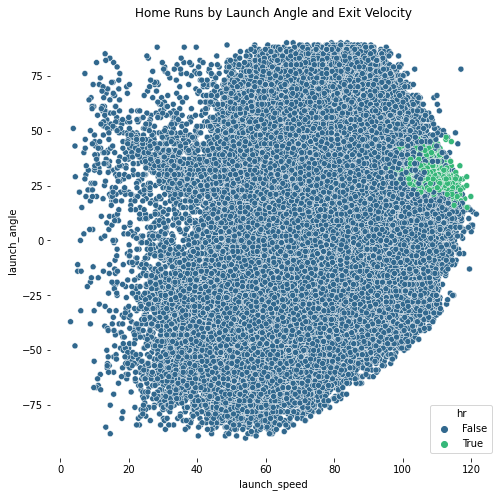

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.despine(fig, left=True, bottom=True)
sns.scatterplot(x="launch_speed", y="launch_angle",
                hue="hr", 
                palette='viridis', 
                data=data2, ax=ax)
ax.set_title("Home Runs by Launch Angle and Exit Velocity");

We can see that home runs make up a certain subset set of launch angles and speeds. While there is some variability (which park the hit occured at and whether it was hit to left / center / right field of that park, they are still mostly determined by this angle and speed. This would make sense from a physics perspective, launch speed and angle would be able to determine the distance the ball will travel. Let's look at the correlation between our factors as well as hr frequency by park and see how well we can get our model to perform.

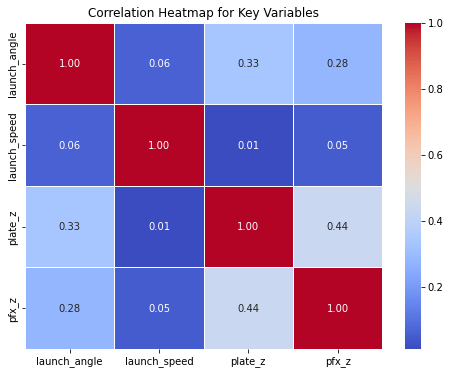

In [8]:
X_factors = ['launch_angle', 'launch_speed', 'plate_z', 'pfx_z']


plt.figure(figsize=(8, 6))
sns.heatmap(data2[X_factors].corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)

plt.title("Correlation Heatmap for Key Variables")
plt.show()


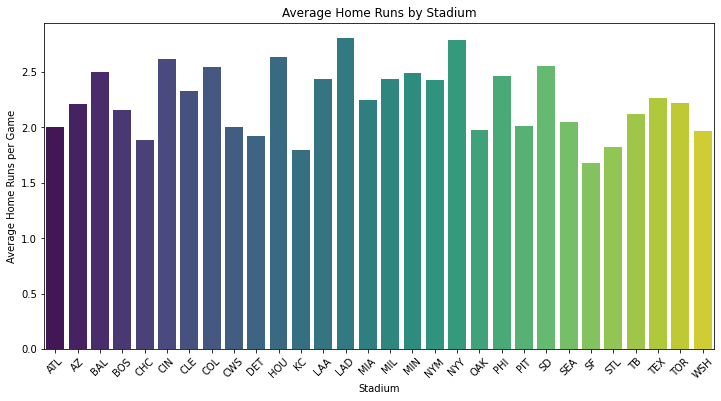

In [9]:
hr_stadiums = data2.groupby(["game_pk", "home_team"]).agg(hr_total=("hr", "sum")).reset_index()
hr_stadiums_avg = hr_stadiums.groupby("home_team")["hr_total"].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.barplot(data=hr_stadiums_avg, x="home_team", y="hr_total", palette="viridis")

plt.xlabel("Stadium")
plt.ylabel("Average Home Runs per Game")
plt.title("Average Home Runs by Stadium")
plt.xticks(rotation=45)  # Rotate labels for readability

plt.show()


As we can see, certain stadiums allow more homeruns on average due to factors like their altitude, dimensions, and outfield fence size. _COL_ is consistently ranked as one of the most home run-friendly ballparks in MLB, while _SF_ is ranked one of the least friendly. Also certain home teams like the NYY and LAD are more likely to hit home runs due to their elite batters. We will convert the home_team into a dummy variable meaning that each team will get its own binary column corresponding to if they are the home team.

In [10]:
data2 = pd.get_dummies(data2, columns=["home_team"])

### Preparing Data for the Neural Network

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
target = "hr"
X_cols = X_factors + list(data2.columns[data2.columns.str.startswith("home_team_")])

data3 = data2.dropna(subset = X_cols + ["hr"])

X = data3[X_cols]
y = data3[target]

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.astype(int).to_numpy().reshape(-1,1)

In [14]:
len(X_cols) # of features for first layer

34

---

# The Neural Network
We will build a multilayered **dense** neural network (meaning every layer is fully connected) with $L$ layers, $34$ input nodes, $L-2$ hidden layers of arbitrary size, and $1$ output node representing the probability of a home run. 

<img src="multilayerPerceptron.jpg" alt="Drawing" style="width: 450px;"/>

For our activation function, we will use the sigmoid function because we want to represent our node's outputs as a probability (similar to Logistic Regression):

* Sigmoid Function
$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

For our cost function, we will again use the  use binary cross entropy:
$$
C(\mathbf{w}, b) = \frac{1}{N}\sum_{i=1}^{N}\Big[ -y^{(i)}\log \hat{y}^{(i)} - (1-y^{(i)}) \log (1 - \hat{y}^{(i)})\Big ]
$$

Due to the complexity of the neural network, we will implement different components as functions and then putthem all into a class.

---

First we will define our sigmoid activation function, its derivative, and the binary cross entropy for each instance of training data.

In [15]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

from math import log

def bce(y_pred, y_true):
    return - (y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))

## Feedforward Phase
After initializing our weights and biases, we pass our input through every layer of the neural network. For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network. 

In [16]:
def initialize_weights(layers = [34, 64, 32, 16, 1]):
    """
    Initialzes random (normal) weights and biases of the appropriate 
    sizes dictated by layers
    """
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # A scaling factor to improve training efficiency
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

def forward_pass(W, B, xi, predict_vector = False):
    """
    Takes weights, biases, and a features vector xi and returns the output
    Either just the output of the last layer (if predict_vector is True)
    or pre and post activation output at each layer
    """
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i].reshape(-1)
       
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]


In [17]:
def binary_cross_entropy(W, B, X, y):
    """
    Takes Weights, Biases, input matrix, and output vector and
    returns average binary_cross_entropy
    """
    cost = 0.0
    m = 0
    
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector=True)[0]
        yi = yi[0]
        # Compute Binary Cross-Entropy Loss
        cost += - (yi * np.log(a) + (1 - yi) * np.log(1 - a))
        
        m += 1

    return cost / m  # Average over all samples

## Backpropogation Phase with Stochastic Gradient Descent 
We will now create a ```DenseNetwork``` class that initializes the weights and bias for the network, and implements stochastic gradient descent shown below:

1. For each $i = 1, \dots, N$.
2. Feedforward $\mathbf{x}^{(i)}$ into the network. 
3. Compute $\delta^{L} = \nabla_aC\otimes \sigma'(\mathbf{z}^{L})$.
4. For $\ell = L-1, \dots, 1$, compute $\delta^{\ell} = \big ( (\mathbf{w}^{\ell + 1})^{T} \delta^{\ell + 1} \Big )\otimes \sigma'(\mathbf{z}^{\ell})$.
5. For $\ell = L, L-1, \dots, 1$, 

$$
w^{\ell} \leftarrow w^{\ell} - \alpha \delta^{\ell}(\mathbf{a}^{\ell-1})^{T}
$$

$$
b^{\ell} \leftarrow b^{\ell} - \alpha \delta^{\ell}
$$


---

In [28]:

class DenseNetwork(object):
    def __init__(self, layers =[34, 64, 32, 16, 1]):
        """
        Initializes layer structure with weights and biases
        """
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.046, epochs = 100):
        """
        Trains the NN on X_train and y_train with learning rate alpha
        in a set number of epochs
        """
        # Print the initial mean squared error
        self.errors_ = [binary_cross_entropy(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    deltas[i] = deltas[i].reshape(-1, 1)  # Shape becomes (64, 1)
                    A[i-1] = A[i-1].reshape(-1, 1)  # Shape becomes (3, 1)

                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(binary_cross_entropy(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        """
        Given a vector xi predicts the output
        """
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return A[-1]
    
   
    def evaluate(self, test_set, solutions, threshold = .5, silent = False):
        """
        Given a test set and solutions, evaluates different metrics
        The threshold is the value at which a probability should be assumed true
        If not silent, prints out a classifcation report of metrics
        Returns f1 score
        """
        # Convert predictions to binary (0 or 1)
        predictions = [(self.predict(test) > threshold) for test in test_set]
        
        if not silent:
            print(classification_report(solutions, predictions))
        
        return f1_score(solutions, predictions)

In [30]:
net = DenseNetwork()
net.train(X_train, y_train, epochs = 25)

Starting Cost = 1.4296780692703108
1-Epoch Cost = 0.1086995517832609
2-Epoch Cost = 0.10791326678692635
3-Epoch Cost = 0.10594036392983064
4-Epoch Cost = 0.09706435459526398
5-Epoch Cost = 0.06445913033326292
6-Epoch Cost = 0.059551249549667964
7-Epoch Cost = 0.05579007147873564
8-Epoch Cost = 0.050491549263018666
9-Epoch Cost = 0.045491189847522186
10-Epoch Cost = 0.042748835157423906
11-Epoch Cost = 0.04145519601522929
12-Epoch Cost = 0.040751596448104756
13-Epoch Cost = 0.04029068680695185
14-Epoch Cost = 0.0399428011222183
15-Epoch Cost = 0.039655924451923806
16-Epoch Cost = 0.039407147468574794
17-Epoch Cost = 0.0391865384959223
18-Epoch Cost = 0.03899007500951125
19-Epoch Cost = 0.03881548054036116
20-Epoch Cost = 0.03866044719794607
21-Epoch Cost = 0.03852258773112948
22-Epoch Cost = 0.038399800008982916
23-Epoch Cost = 0.03829039968919282
24-Epoch Cost = 0.03819305060637641
25-Epoch Cost = 0.03810664062550013


In [31]:
net.evaluate(X_test, y_test, .5)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99     45396
        True       0.69      0.49      0.57      1060

    accuracy                           0.98     46456
   macro avg       0.84      0.74      0.78     46456
weighted avg       0.98      0.98      0.98     46456



0.5687465488680287

### Interpreting Results

Overall, our model is highly accurate (98%) at determining home runs, but it struggle with recall (49%) for actual HRs. This means that it misses home runs about half the home runs. Our precision for HRs is 69%, indicating that when it does predict a home run, it's correct most of the time. This could be due to the data imbalance between home runs (1060) vs non home runs (45396). 

---

Additionally, our probability cut off might suboptimal. The best way to determine this threshold would be to use a validation set, especially if we want our model to generalize to other testing data. However, we will just test against the training set to see how much the threshhold might differ from .5 for predicting home runs. Below we have some code that will determine the threshold that maximizes the f1 score - a measure between precision (how many predicted HRs are actually HRs) and recall (how many actual HRs were caught).

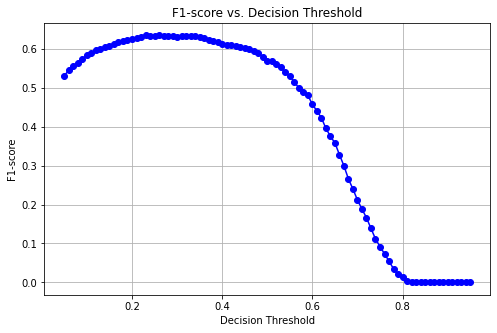

In [33]:
thresholds = [.01 * i for i in range(5,96)]
f1_scores = [net.evaluate(X_test, y_test, thresh, silent = True) for thresh in thresholds]

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o', linestyle='-', color='b')

plt.xlabel("Decision Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs. Decision Threshold")
plt.grid(True)

plt.show()


In [34]:
thresh = thresholds[np.argmax(f1_scores)]
print(thresh)
net.evaluate(X_test, y_test, thresh)

0.26
              precision    recall  f1-score   support

       False       0.99      0.98      0.99     45396
        True       0.54      0.77      0.63      1060

    accuracy                           0.98     46456
   macro avg       0.77      0.88      0.81     46456
weighted avg       0.98      0.98      0.98     46456



0.6343544009305933

Using the threshold (meaning any probabilitity of .26 or higher is determined to be a home run) maximizes our f1 score. This  increases the recall for home runs to 77% meaning the model now captures more actual HRs. However, it also decreased the precision dropping to 54%, meaning that the model now misclassifies more non-HRs as home runs. So our model is now better at detecting HRs, but less confident that its HR predictions are correct. Thus this threshold is better for detecting as many HRs as possible but is more likely to falsely predict home runs. This intuitively makes sense as we significantly decreased the required belief needed to classify a homerun.

---

In conclusion, our model is able to identify non-home runs as non-home runs almost perfectly. However, in its current form, we have to decide if we want to prioritize a high degree of confidence in our home runs, potentially missing some, or if we would rather catch most of them but accidentally classify some home runs as home runs. While there might be other ways to optimize the neural network depending on its specefic goals, as it stands right now it is quite accurate correctly classifying hits 98% of the time.